In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd
from NS_model_tf import Sampler, Navier_Stokes2D
import os
os.environ["KMP_WARNINGS"] = "FALSE" 
import timeit

def U_gamma_1(x):
    num = x.shape[0]
    return np.tile(np.array([1.0, 0.0]), (num, 1))


def U_gamma_2(x):
    num = x.shape[0]
    return np.zeros((num, 2))


def f(x):
    num = x.shape[0]
    return np.zeros((num, 2))

def operator(psi, p, x, y, Re, sigma_x=1.0, sigma_y=1.0):
    u = tf.gradients(psi, y)[0] / sigma_y
    v = - tf.gradients(psi, x)[0] / sigma_x

    u_x = tf.gradients(u, x)[0] / sigma_x
    u_y = tf.gradients(u, y)[0] / sigma_y

    v_x = tf.gradients(v, x)[0] / sigma_x
    v_y = tf.gradients(v, y)[0] / sigma_y

    p_x = tf.gradients(p, x)[0] / sigma_x
    p_y = tf.gradients(p, y)[0] / sigma_y

    u_xx = tf.gradients(u_x, x)[0] / sigma_x
    u_yy = tf.gradients(u_y, y)[0] / sigma_y

    v_xx = tf.gradients(v_x, x)[0] / sigma_x
    v_yy = tf.gradients(v_y, y)[0] / sigma_y

    Ru_momentum = u * u_x + v * u_y + p_x - (u_xx + u_yy) / Re
    Rv_momentum = u * v_x + v * v_y + p_y - (v_xx + v_yy) / Re

    return Ru_momentum, Rv_momentum


In [2]:

class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name=None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name

    def sample(self, N):
        x = self.coords[0:1, :] + (self.coords[1:2, :] - self.coords[0:1, :]) * np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y

class Navier_Stokes2D:
    def __init__(self, layers, operator, bcs_sampler, res_sampler, Re, model):
        # Normalization constants
        X, _ = res_sampler.sample(np.int32(1e5))
        self.mu_X, self.sigma_X = X.mean(0), X.std(0)
        self.mu_x, self.sigma_x = self.mu_X[0], self.sigma_X[0]
        self.mu_y, self.sigma_y = self.mu_X[1], self.sigma_X[1]

        # Samplers
        self.operator = operator
        self.bcs_sampler = bcs_sampler
        self.res_sampler = res_sampler

        # Choose model
        self.model = model

        # Navier Stokes constant
        self.Re = tf.constant(Re, dtype=tf.float32)

        # Adaptive re-weighting constant
        self.beta = 0.9
        self.adaptive_constant_bcs_val = np.array(2.0)
        self.adaptive_constant_bcs1_u_val = np.array(2.0)
        self.adaptive_constant_bcs1_v_val = np.array(2.0)
        self.adaptive_constant_bcs2_u_val = np.array(2.0)
        self.adaptive_constant_bcs2_v_val = np.array(2.0)
        self.adaptive_constant_bcs3_u_val = np.array(2.0)
        self.adaptive_constant_bcs3_v_val = np.array(2.0)
        self.adaptive_constant_bcs4_u_val = np.array(2.0)
        self.adaptive_constant_bcs4_v_val = np.array(2.0)

        # self.adaptive_constant_bcs2_val = np.array(2.0)
        # self.adaptive_constant_bcs3_val = np.array(2.0)
        # self.adaptive_constant_bcs4_val = np.array(2.0)

        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))

        # Initialize network weights and biases
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)

        if model in ['M3', 'M4']:
            # Initialize encoder weights and biases
            self.encoder_weights_1 = self.xavier_init([2, layers[1]])
            self.encoder_biases_1 = self.xavier_init([1, layers[1]])

            self.encoder_weights_2 = self.xavier_init([2, layers[1]])
            self.encoder_biases_2 = self.xavier_init([1, layers[1]])

        # Define placeholders and computational graph
        self.x_u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_u_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.v_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        # self.U_bc2_tf = tf.placeholder(tf.float32, shape=(None, 2))

        self.x_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
        # self.U_bc3_tf = tf.placeholder(tf.float32, shape=(None, 2))

        self.x_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))
        # self.U_bc4_tf = tf.placeholder(tf.float32, shape=(None, 2))

        self.x_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_r_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.adaptive_constant_bcs_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_bcs_val.shape)
        self.adaptive_constant_bcs1_u_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_bcs1_u_val.shape)
        self.adaptive_constant_bcs1_v_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_bcs1_v_val.shape)

        self.adaptive_constant_bcs2_u_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_bcs2_u_val.shape)
        self.adaptive_constant_bcs2_v_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_bcs2_v_val.shape)

        self.adaptive_constant_bcs3_u_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_bcs3_u_val.shape)
        self.adaptive_constant_bcs3_v_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_bcs3_v_val.shape)

        self.adaptive_constant_bcs4_u_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_bcs4_u_val.shape)
        self.adaptive_constant_bcs4_v_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_bcs4_v_val.shape)

        # self.adaptive_constant_bcs2_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_bcs2_val.shape)
        # self.adaptive_constant_bcs3_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_bcs3_val.shape)
        # self.adaptive_constant_bcs4_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_bcs4_val.shape)

        # Evaluate predictions
        self.u_bc1_pred, self.v_bc1_pred = self.net_uv(self.x_bc1_tf, self.y_bc1_tf)
        self.u_bc2_pred, self.v_bc2_pred = self.net_uv(self.x_bc2_tf, self.y_bc2_tf)
        self.u_bc3_pred, self.v_bc3_pred = self.net_uv(self.x_bc3_tf, self.y_bc3_tf)
        self.u_bc4_pred, self.v_bc4_pred = self.net_uv(self.x_bc4_tf, self.y_bc4_tf)

        # self.U_bc1_pred = tf.concat([self.u_bc1_pred, self.v_bc1_pred], axis=1)
        # self.U_bc2_pred = tf.concat([self.u_bc2_pred, self.v_bc2_pred], axis=1)
        # self.U_bc3_pred = tf.concat([self.u_bc3_pred, self.v_bc3_pred], axis=1)
        # self.U_bc4_pred = tf.concat([self.u_bc4_pred, self.v_bc4_pred], axis=1)

        self.psi_pred, self.p_pred = self.net_psi_p(self.x_u_tf, self.y_u_tf)
        self.u_pred, self.v_pred = self.net_uv(self.x_u_tf, self.y_u_tf)
        self.u_momentum_pred, self.v_momentum_pred = self.net_r(self.x_r_tf, self.y_r_tf)

        # Residual loss
        self.loss_u_momentum = tf.reduce_mean(tf.square(self.u_momentum_pred))
        self.loss_v_momentum = tf.reduce_mean(tf.square(self.v_momentum_pred))

        self.loss_res = self.loss_u_momentum + self.loss_v_momentum
        
        # Boundary loss
        self.loss_bc1_u = tf.reduce_mean(tf.square(self.u_bc1_pred - self.u_bc1_tf)) 
        self.loss_bc1_v = tf.reduce_mean(tf.square(self.v_bc1_pred - self.v_bc1_tf))

        self.loss_bc1 =  self.loss_bc1_u  + self.loss_bc1_v

        self.loss_bc2_u = tf.reduce_mean(tf.square(self.u_bc2_pred)) 
        self.loss_bc2_v = tf.reduce_mean(tf.square(self.v_bc2_pred))

        self.loss_bc2 =  self.loss_bc2_u  + self.loss_bc2_v

        self.loss_bc3_u = tf.reduce_mean(tf.square(self.u_bc3_pred)) 
        self.loss_bc3_v = tf.reduce_mean(tf.square(self.v_bc3_pred))

        self.loss_bc3 =  self.loss_bc3_u  + self.loss_bc3_v

        self.loss_bc4_u = tf.reduce_mean(tf.square(self.u_bc4_pred)) 
        self.loss_bc4_v = tf.reduce_mean(tf.square(self.v_bc4_pred))
        
        self.loss_bc4 =  self.loss_bc4_u  + self.loss_bc4_v

        self.loss_bcs = self.loss_bc1 + self.loss_bc2  + self.loss_bc3 + self.loss_bc4
        
        # Total loss
        self.loss = self.loss_res +  \
        self.adaptive_constant_bcs1_u_tf * tf.reduce_mean(tf.square(self.u_bc1_pred - self.u_bc1_tf)) +  self.adaptive_constant_bcs1_v_tf *  tf.reduce_mean(tf.square(self.v_bc1_pred - self.v_bc1_tf)) +\
        self.adaptive_constant_bcs2_u_tf * tf.reduce_mean(tf.square(self.u_bc2_pred)) + self.adaptive_constant_bcs2_v_tf *tf.reduce_mean(tf.square(self.v_bc2_pred)) + \
        self.adaptive_constant_bcs3_u_tf * tf.reduce_mean(tf.square(self.u_bc3_pred)) + self.adaptive_constant_bcs3_v_tf *tf.reduce_mean(tf.square(self.v_bc3_pred)) +\
        self.adaptive_constant_bcs4_u_tf * tf.reduce_mean(tf.square(self.u_bc4_pred)) + self.adaptive_constant_bcs4_v_tf *tf.reduce_mean(tf.square(self.v_bc4_pred)) 

        # Define optimizer with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,
                                                        1000, 0.9, staircase=False)
        # Passing global_step to minimize() will increment it at each step.
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)

        # # Logger
        # self.loss_res_log = []
        # self.loss_bcs_log = []
        # self.saver = tf.train.Saver()

        # # Generate dicts for gradients storage
        # self.dict_gradients_res_layers = self.generate_grad_dict(self.layers)
        # self.dict_gradients_bcs_layers = self.generate_grad_dict(self.layers)

        # # Gradients Storage
        # self.grad_res = []
        # self.grad_bcs = []
        # for i in range(len(self.layers) - 1):
        #     self.grad_res.append(tf.gradients(self.loss_res, self.weights[i])[0])
        #     self.grad_bcs.append(tf.gradients(self.loss_bcs, self.weights[i])[0])

        # self.adpative_constant_bcs_list = []
        # self.adpative_constant_bcs_log = []

        # for i in range(len(self.layers) - 1):
        #     self.adpative_constant_bcs_list.append(
        #         tf.reduce_max(tf.abs(self.grad_res[i])) / tf.reduce_mean(tf.abs(self.grad_bcs[i])))
        # self.adaptive_constant_bcs = tf.reduce_max(tf.stack(self.adpative_constant_bcs_list))

        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
        
    def generate_grad_dict(self, layers):
        num = len(layers) - 1
        grad_dict = {}
        for i in range(num):
            grad_dict['layer_{}'.format(i + 1)] = []
        return grad_dict
    
    # Save gradients during training
    def save_gradients(self, tf_dict):
        num_layers = len(self.layers)
        for i in range(num_layers - 1):
            grad_res_value, grad_bcs_value = self.sess.run([self.grad_res[i], self.grad_bcs[i]], feed_dict=tf_dict)

            # save gradients of loss_r and loss_u
            self.dict_gradients_res_layers['layer_' + str(i + 1)].append(grad_res_value.flatten())
            self.dict_gradients_bcs_layers['layer_' + str(i + 1)].append(grad_bcs_value.flatten())
        return None

    # Xavier initialization
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
        return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,
                           dtype=tf.float32)

    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    # Evaluates the forward pass
    def forward_pass(self, H):
        if self.model in ['M1', 'M2']:
            num_layers = len(self.layers)
            for l in range(0, num_layers - 2):
                W = self.weights[l]
                b = self.biases[l]
                H = tf.tanh(tf.add(tf.matmul(H, W), b))
            W = self.weights[-1]
            b = self.biases[-1]
            H = tf.add(tf.matmul(H, W), b)
            return H

        if self.model in ['M3', 'M4']:
            num_layers = len(self.layers)
            encoder_1 = tf.tanh(tf.add(tf.matmul(H, self.encoder_weights_1), self.encoder_biases_1))
            encoder_2 = tf.tanh(tf.add(tf.matmul(H, self.encoder_weights_2), self.encoder_biases_2))

            for l in range(0, num_layers - 2):
                W = self.weights[l]
                b = self.biases[l]
                H = tf.math.multiply(tf.tanh(tf.add(tf.matmul(H, W), b)), encoder_1) + \
                    tf.math.multiply(1 - tf.tanh(tf.add(tf.matmul(H, W), b)), encoder_2)

            W = self.weights[-1]
            b = self.biases[-1]
            H = tf.add(tf.matmul(H, W), b)
            return H

    # Forward pass for stream-pressure formulation
    def net_psi_p(self, x, y):
        psi_p = self.forward_pass(tf.concat([x, y], 1))
        psi = psi_p[:, 0:1]
        p = psi_p[:, 1:2]
        return psi, p

    # Forward pass for velocities
    def net_uv(self, x, y):
        psi, p = self.net_psi_p(x, y)
        u = tf.gradients(psi, y)[0] / self.sigma_y
        v = - tf.gradients(psi, x)[0] / self.sigma_x
        return u, v

    # Forward pass for residual
    def net_r(self, x, y):
        psi, p = self.net_psi_p(x, y)
        u_momentum_pred, v_momentum_pred = self.operator(psi, p, x, y,
                                                         self.Re,
                                                         self.sigma_x, self.sigma_y)

        return u_momentum_pred, v_momentum_pred

    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        X = (X - self.mu_X) / self.sigma_X
        return X, Y

    # Trains the model by minimizing the MSE loss
    def train(self, nIter=10000, batch_size=128):

        start_time = timeit.default_timer()
        for it in range(1,nIter):
            # Fetch boundary mini-batches
            X_bc1_batch, u_bc1_batch = self.fetch_minibatch(self.bcs_sampler[0], batch_size)
            X_bc2_batch, _ = self.fetch_minibatch(self.bcs_sampler[1], batch_size)
            X_bc3_batch, _ = self.fetch_minibatch(self.bcs_sampler[2], batch_size)
            X_bc4_batch, _ = self.fetch_minibatch(self.bcs_sampler[3], batch_size)

            # Fetch residual mini-batch
            X_res_batch, _ = self.fetch_minibatch(self.res_sampler, batch_size)

            # Define a dictionary for associating placeholders with data
            tf_dict = {self.x_bc1_tf: X_bc1_batch[:, 0:1], self.y_bc1_tf: X_bc1_batch[:, 1:2],
                       self.u_bc1_tf: u_bc1_batch[:, 0:1], self.v_bc1_tf: u_bc1_batch[:, 1:2],
                       self.x_bc2_tf: X_bc2_batch[:, 0:1], self.y_bc2_tf: X_bc2_batch[:, 1:2],
                       self.x_bc3_tf: X_bc3_batch[:, 0:1], self.y_bc3_tf: X_bc3_batch[:, 1:2],
                       self.x_bc4_tf: X_bc4_batch[:, 0:1], self.y_bc4_tf: X_bc4_batch[:, 1:2],
                       self.x_r_tf: X_res_batch[:, 0:1], self.y_r_tf: X_res_batch[:, 1:2],
                       self.adaptive_constant_bcs_tf: self.adaptive_constant_bcs_val,
                       self.adaptive_constant_bcs1_u_tf: self.adaptive_constant_bcs1_u_val,
                       self.adaptive_constant_bcs1_v_tf: self.adaptive_constant_bcs1_v_val,
                      self.adaptive_constant_bcs2_u_tf: self.adaptive_constant_bcs2_u_val,
                       self.adaptive_constant_bcs2_v_tf: self.adaptive_constant_bcs2_v_val,
                      self.adaptive_constant_bcs3_u_tf: self.adaptive_constant_bcs3_u_val,
                       self.adaptive_constant_bcs3_v_tf: self.adaptive_constant_bcs3_v_val,
                      self.adaptive_constant_bcs4_u_tf: self.adaptive_constant_bcs4_u_val,
                       self.adaptive_constant_bcs4_v_tf: self.adaptive_constant_bcs4_v_val
                       }

            # Run the Tensorflow session to minimize the loss
            self.sess.run(self.train_op, tf_dict)

            # Print
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time
                loss, loss_res , loss_bcs ,  loss_bc1_u, loss_bc1_v,loss_bc2_u,  loss_bc2_v ,  loss_bc3_u,  loss_bc3_v , loss_bc4_u,  loss_bc4_v , = self.sess.run([self.loss, self.loss_res,
                                                                                                                                                                    self.loss_bcs,
                                                                                                                                                                    self.loss_bc1_u, self.loss_bc1_v, 
                                                                                                                                                                    self.loss_bc2_u,  self.loss_bc2_v,
                                                                                                                                                                    self.loss_bc3_u,  self.loss_bc3_v,
                                                                                                                                                                    self.loss_bc4_u,  self.loss_bc4_v
                                                                                                                                                                      ], tf_dict)

                print('It: %d, Loss: %.3e, Loss_r: %.3e, loss_bc: %.3e, Time: %.2f' % (it, loss, loss_res, loss_bcs , elapsed))

                if it % 1000 == 0:
                    if self.model in ['M2', 'M4']:
                        # Compute the adaptive constant

                        alpha = 1000
                        # adaptive_constant_bcs_val = self.sess.run(self.adaptive_constant_bcs, tf_dict)

                        # self.adaptive_constant_bcs_val = adaptive_constant_bcs_val * (1.0 - self.beta) + self.beta * self.adaptive_constant_bcs_val
                        self.adaptive_constant_bcs1_val_u = alpha * loss_bc1_u
                        self.adaptive_constant_bcs1_val_v = alpha * loss_bc1_v
                        self.adaptive_constant_bcs2_val_u = alpha * loss_bc2_u
                        self.adaptive_constant_bcs2_val_v = alpha * loss_bc2_v
                        self.adaptive_constant_bcs3_val_u = alpha * loss_bc3_u
                        self.adaptive_constant_bcs3_val_v = alpha * loss_bc3_v
                        self.adaptive_constant_bcs4_val_u = alpha * loss_bc4_u
                        self.adaptive_constant_bcs4_val_v = alpha * loss_bc4_v

                        print("adaptive_constant_bcs1_val_u: {:.3f}".format(self.adaptive_constant_bcs1_val_u))
                        print("adaptive_constant_bcs1_val_v: {:.3f}".format(self.adaptive_constant_bcs1_val_v))
                        print("adaptive_constant_bcs2_val_u: {:.3f}".format(self.adaptive_constant_bcs2_val_u))
                        print("adaptive_constant_bcs2_val_v: {:.3f}".format(self.adaptive_constant_bcs2_val_v))
                        print("adaptive_constant_bcs3_val_u: {:.3f}".format(self.adaptive_constant_bcs3_val_u))
                        print("adaptive_constant_bcs3_val_v: {:.3f}".format(self.adaptive_constant_bcs3_val_v))
                        print("adaptive_constant_bcs4_val_u: {:.3f}".format(self.adaptive_constant_bcs4_val_u))
                        print("adaptive_constant_bcs4_val_v: {:.3f}".format(self.adaptive_constant_bcs4_val_v))

                    start_time = timeit.default_timer()

            # Store gradients
            if it % 10000 == 0:
                # self.save_gradients(tf_dict)
                print("Gradients information stored ...")

    # Evaluates predictions at test points
    def predict_psi_p(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.x_u_tf: X_star[:, 0:1], self.y_u_tf: X_star[:, 1:2]}
        psi_star = self.sess.run(self.psi_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)
        return psi_star, p_star

    def predict_uv(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.x_u_tf: X_star[:, 0:1], self.y_u_tf: X_star[:, 1:2]}
        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        return u_star, v_star



In [3]:

# Parameters of equations
Re = 100.0

# Domain boundaries
bc1_coords = np.array([[0.0, 1.0], [1.0, 1.0]])
bc2_coords = np.array([[0.0, 0.0], [0.0, 1.0]])
bc3_coords = np.array([[1.0, 0.0], [1.0, 1.0]])
bc4_coords = np.array([[0.0, 0.0],[1.0, 0.0]])
dom_coords = np.array([[0.0, 0.0],
                        [1.0, 1.0]])

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: U_gamma_1(x), name='Dirichlet BC1')
bc2 = Sampler(2, bc2_coords, lambda x: U_gamma_2(x), name='Dirichlet BC2')
bc3 = Sampler(2, bc3_coords, lambda x: U_gamma_2(x), name='Dirichlet BC3')
bc4 = Sampler(2, bc4_coords, lambda x: U_gamma_2(x), name='Dirichlet BC4')
bcs_sampler = [bc1, bc2, bc3, bc4]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: f(x), name='Forcing')

# Define model
mode = 'M2'
layers = [2, 50, 50, 50, 2]

model = Navier_Stokes2D(layers, operator, bcs_sampler, res_sampler, Re, mode)


2023-11-20 22:30:09.775067: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 22:30:09.802914: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2899885000 Hz
2023-11-20 22:30:09.803376: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561435711730 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-11-20 22:30:09.803397: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-11-20 22:30:09.804379: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:

# Train model
model.train(nIter=40001, batch_size=128)


ValueError: too many values to unpack (expected 11)

In [5]:


# Test Data
nx = 100
ny = 100  # change to 100
x = np.linspace(0.0, 1.0, nx)
y = np.linspace(0.0, 1.0, ny)
X, Y = np.meshgrid(x, y)

X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

# Predictions
psi_pred, p_pred = model.predict_psi_p(X_star)
u_pred, v_pred = model.predict_uv(X_star)

psi_star = griddata(X_star, psi_pred.flatten(), (X, Y), method='cubic')
p_star = griddata(X_star, p_pred.flatten(), (X, Y), method='cubic')
u_star = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')
v_star = griddata(X_star, v_pred.flatten(), (X, Y), method='cubic')

velocity = np.sqrt(u_pred**2 + v_pred**2)
velocity_star = griddata(X_star, velocity.flatten(), (X, Y), method='cubic')

# Reference
u_ref= np.genfromtxt("reference_u.csv", delimiter=',')
v_ref= np.genfromtxt("reference_v.csv", delimiter=',')
velocity_ref = np.sqrt(u_ref**2 + v_ref**2)

u_pred = u_pred.reshape(100,100)
v_pred = v_pred.reshape(100,100)
p_pred = p_pred.reshape(100,100)

# Relative error
error = np.linalg.norm(u_ref - u_pred.T, 2) / np.linalg.norm(u_ref, 2)
print('l2 error: {:.2e}'.format(error))
error = np.linalg.norm(v_ref - v_pred.T, 2) / np.linalg.norm(v_ref, 2)
print('l2 error: {:.2e}'.format(error))
error = np.linalg.norm(p_pred - p_star.T, 2) / np.linalg.norm(p_star, 2)
print('l2 error: {:.2e}'.format(error))

### Plot ###
###########


l2 error: 8.30e-01
l2 error: 9.24e-01
l2 error: 1.05e-01


In [15]:


# Test Data
nx = 100
ny = 100  # change to 100
x = np.linspace(0.0, 1.0, nx)
y = np.linspace(0.0, 1.0, ny)
X, Y = np.meshgrid(x, y)

X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

# Predictions
psi_pred, p_pred = model.predict_psi_p(X_star)
u_pred, v_pred = model.predict_uv(X_star)

psi_star = griddata(X_star, psi_pred.flatten(), (X, Y), method='cubic')
p_star = griddata(X_star, p_pred.flatten(), (X, Y), method='cubic')
u_star = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')
v_star = griddata(X_star, v_pred.flatten(), (X, Y), method='cubic')

velocity = np.sqrt(u_pred**2 + v_pred**2)
velocity_star = griddata(X_star, velocity.flatten(), (X, Y), method='cubic')

# Reference
u_ref= np.genfromtxt("reference_u.csv", delimiter=',')
v_ref= np.genfromtxt("reference_v.csv", delimiter=',')
velocity_ref = np.sqrt(u_ref**2 + v_ref**2)

u_pred = u_pred.reshape(100,100)
v_pred = v_pred.reshape(100,100)
p_pred = p_pred.reshape(100,100)

# Relative error
error = np.linalg.norm(u_ref - u_pred.T, 2) / np.linalg.norm(u_ref, 2)
print('l2 error: {:.2e}'.format(error))
error = np.linalg.norm(v_ref - v_pred.T, 2) / np.linalg.norm(v_ref, 2)
print('l2 error: {:.2e}'.format(error))
error = np.linalg.norm(p_pred - p_star.T, 2) / np.linalg.norm(p_star, 2)
print('l2 error: {:.2e}'.format(error))

### Plot ###
###########


l2 error: 5.93e-01
l2 error: 1.00e+00
l2 error: 8.37e-03


In [9]:


# Test Data
nx = 100
ny = 100  # change to 100
x = np.linspace(0.0, 1.0, nx)
y = np.linspace(0.0, 1.0, ny)
X, Y = np.meshgrid(x, y)

X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

# Predictions
psi_pred, p_pred = model.predict_psi_p(X_star)
u_pred, v_pred = model.predict_uv(X_star)

psi_star = griddata(X_star, psi_pred.flatten(), (X, Y), method='cubic')
p_star = griddata(X_star, p_pred.flatten(), (X, Y), method='cubic')
u_star = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')
v_star = griddata(X_star, v_pred.flatten(), (X, Y), method='cubic')

velocity = np.sqrt(u_pred**2 + v_pred**2)
velocity_star = griddata(X_star, velocity.flatten(), (X, Y), method='cubic')

# Reference
u_ref= np.genfromtxt("reference_u.csv", delimiter=',')
v_ref= np.genfromtxt("reference_v.csv", delimiter=',')
velocity_ref = np.sqrt(u_ref**2 + v_ref**2)

# Relative error
error = np.linalg.norm(velocity_star - velocity_ref.T, 2) / np.linalg.norm(velocity_ref, 2)
print('l2 error: {:.2e}'.format(error))

### Plot ###
###########


l2 error: 6.61e-01


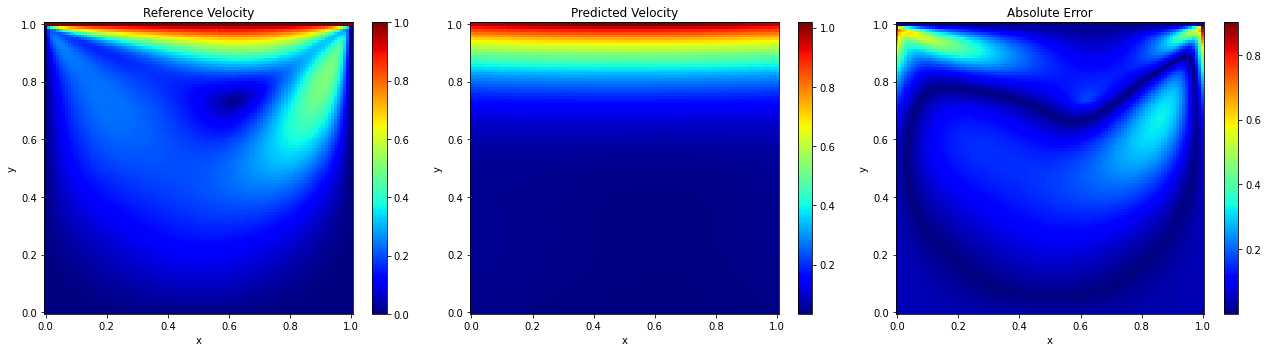

In [6]:

# Reference solution & Prediceted solution
fig_1 = plt.figure(1, figsize=(18, 5))
fig_1.add_subplot(1, 3, 1)
plt.pcolor(X.T, Y.T, velocity_ref, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Reference Velocity')

fig_1.add_subplot(1, 3, 2)
plt.pcolor(X, Y, velocity_star, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted Velocity')
plt.tight_layout()

fig_1.add_subplot(1, 3, 3)
plt.pcolor(X, Y, np.abs(velocity_star - velocity_ref.T), cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Absolute Error')
plt.show()


In [14]:
p_pred.shape

(10000, 1)

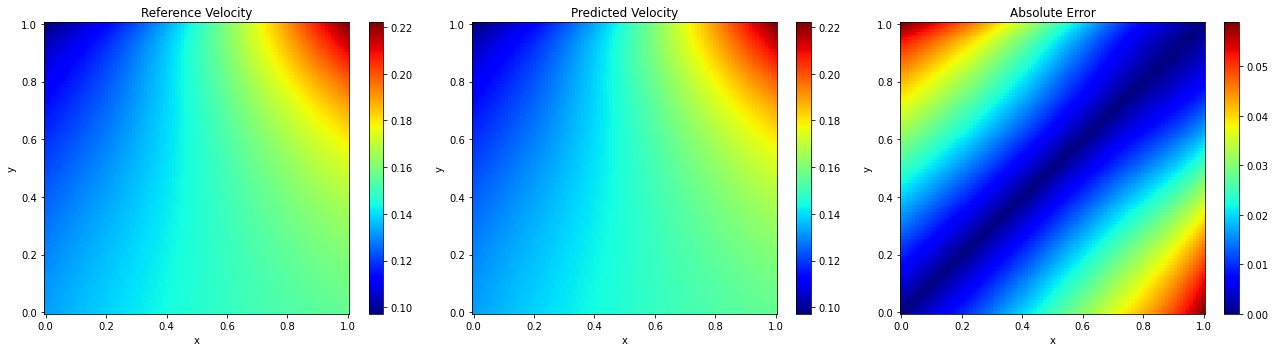

In [7]:

# Reference solution & Prediceted solution
fig_1 = plt.figure(1, figsize=(18, 5))
fig_1.add_subplot(1, 3, 1)
plt.pcolor(X, Y, p_star, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Reference Velocity')

fig_1.add_subplot(1, 3, 2)
plt.pcolor(x, Y, p_pred, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted Velocity')
plt.tight_layout()

fig_1.add_subplot(1, 3, 3)
plt.pcolor(X, Y, np.abs(p_star - p_pred.T), cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Absolute Error')
plt.show()


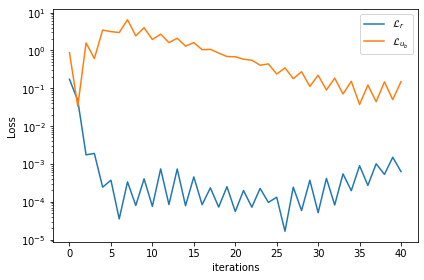

In [22]:

    ## Loss ##
loss_res = model.loss_res_log
loss_bcs = model.loss_bcs_log

fig_2 = plt.figure(2)
ax = fig_2.add_subplot(1, 1, 1)
ax.plot(loss_res, label='$\mathcal{L}_{r}$')
ax.plot(loss_bcs, label='$\mathcal{L}_{u_b}$')
ax.set_yscale('log')
ax.set_xlabel('iterations')
ax.set_ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


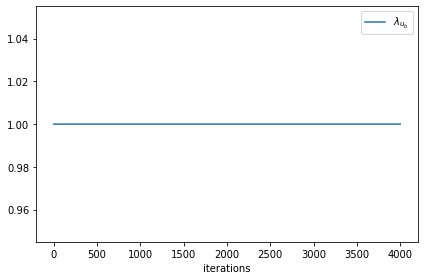

In [8]:

## Adaptive Constant
adaptive_constant = model.adpative_constant_bcs_log
    
fig_3 = plt.figure(3)
ax = fig_3.add_subplot(1, 1, 1)
ax.plot(adaptive_constant, label='$\lambda_{u_b}$')
ax.set_xlabel('iterations')
plt.legend()
plt.tight_layout()
plt.show()

/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

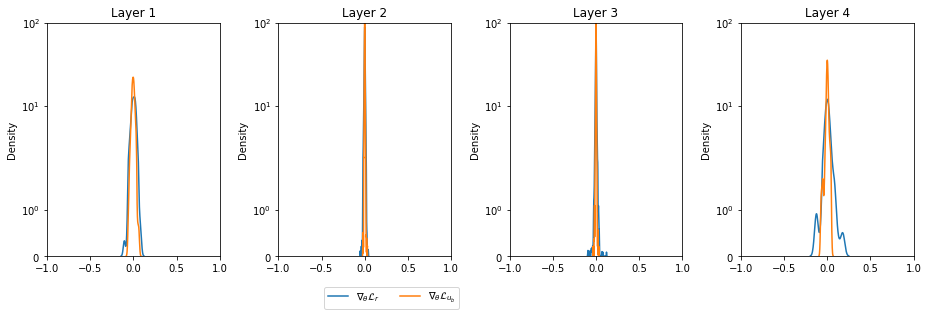

In [10]:
## Gradients #
data_gradients_res = model.dict_gradients_res_layers
data_gradients_bcs = model.dict_gradients_bcs_layers

num_hidden_layers = len(layers) -1
cnt = 1
fig_4 = plt.figure(4, figsize=(13, 4))
for j in range(num_hidden_layers):
    ax = plt.subplot(1, 4, cnt)
    ax.set_title('Layer {}'.format(j + 1))
    ax.set_yscale('symlog')
    gradients_res = data_gradients_res['layer_' + str(j + 1)][-1]
    gradients_bcs = data_gradients_bcs['layer_' + str(j + 1)][-1]
    
    sns.distplot(gradients_res, hist=False,
                    kde_kws={"shade": False},
                    norm_hist=True, label=r'$\nabla_\theta \mathcal{L}_r$')
    sns.distplot(gradients_bcs, hist=False,
                    kde_kws={"shade": False},
                    norm_hist=True, label=r'$\nabla_\theta \mathcal{L}_{u_b}$')

    # ax.get_legend().remove()
    ax.set_xlim([-1.0, 1.0])
    ax.set_ylim([0, 100])
    cnt += 1
handles, labels = ax.get_legend_handles_labels()

fig_4.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.35, -0.01),
            borderaxespad=0, bbox_transform=fig_4.transFigure, ncol=2)
plt.tight_layout()
plt.show()
